# 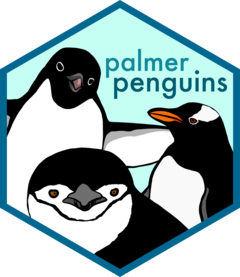



# About the data

---
The data was collected and made available by [Dr. Kristen Gorman](https://www.uaf.edu/cfos/people/faculty/detail/kristen-gorman.php) and the [Palmer Station, Antarctica LTER](https://pal.lternet.edu/), a member of the [Long Term Ecological Research Network](https://lternet.edu/).

It contains data for 344 penguins. There are 3 different species of penguins in this dataset, collected from 3 islands in the Palmer Archipelago, Antarctica.

# Import Libraries

We first import the libraries that we will use in the notebook.

In [ ]:
import pandas as pd # For dataframe manipulation
import numpy as np # For arrays and matrices manipulation
import networkx as nx # For graph manipulation

# For machine leaning pre processing and modelling
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn import metrics

# For plotting charts and diagrams
import matplotlib.cm as cm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 

# For general use
from random import *

# Data Preprocessing

Before clustering our dataset, we will pre process it to understand the data, make it suitable for the modelling and making sure that we are extracting the most information from it.

## Load data

We first import the penguins dataset.



In [ ]:
%pip install palmerpenguins #use "!pip install palmerpenguins" if it doesn't work with %
from palmerpenguins import load_penguins
penguins = load_penguins()

## Data Description

We collect some general information about the dataset to understand the data.

In [ ]:
print("The dataset contains the columns: ", penguins.columns.values)

The dataset contains the columns:  ['species' 'island' 'bill_length_mm' 'bill_depth_mm' 'flipper_length_mm'
 'body_mass_g' 'sex' 'year']


`DataFrame.info()` gives us an overview of the number of samples, features, features types and number of missing values per feature.

In [ ]:
penguins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
 7   year               344 non-null    int64  
dtypes: float64(4), int64(1), object(3)
memory usage: 21.6+ KB


To summarize, our dataset contains **344 samples** and: 

*   **2 categorical features:** island and sex
*   **4 continuous features:** bill_length_mm, bill_depth_mm, flipper_length_mm, and body_mass_g
*   **One discrete feature:** year
*   **1 categorical target variable:** species

The target variable contains **3 classes**. Therefore, we expect to cluster the data into three clusters corresponding to the species of the penguins. 


## Data Exploration


Let's display some random rows in the dataset to see how the penguins dataset looks like.

In [ ]:
penguins.take(np.random.permutation(len(penguins))[:10])

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
276,Chinstrap,Dream,46.5,17.9,192.0,3500.0,female,2007
141,Adelie,Dream,40.6,17.2,187.0,3475.0,male,2009
184,Gentoo,Biscoe,45.1,14.5,207.0,5050.0,female,2007
247,Gentoo,Biscoe,50.8,15.7,226.0,5200.0,male,2009
339,Chinstrap,Dream,55.8,19.8,207.0,4000.0,male,2009
10,Adelie,Torgersen,37.8,17.1,186.0,3300.0,NaN,2007
321,Chinstrap,Dream,50.8,18.5,201.0,4450.0,male,2009
340,Chinstrap,Dream,43.5,18.1,202.0,3400.0,female,2009
111,Adelie,Biscoe,45.6,20.3,191.0,4600.0,male,2009
83,Adelie,Torgersen,35.1,19.4,193.0,4200.0,male,2008


We print the **correlation matrix** and **correlation heatmap**.

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year
bill_length_mm,1.000000,-0.235053,0.656181,0.595110,0.054545
bill_depth_mm,-0.235053,1.000000,-0.583851,-0.471916,-0.060354
flipper_length_mm,0.656181,-0.583851,1.000000,0.871202,0.169675
body_mass_g,0.595110,-0.471916,0.871202,1.000000,0.042209
year,0.054545,-0.060354,0.169675,0.042209,1.000000


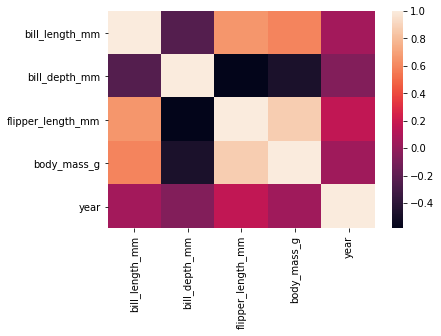

In [ ]:
sns.heatmap(penguins.corr())
penguins.corr()

The correlation matrix indicates a **high correlation** (0.87) between *body_mass* and *flipper_length_mm* features. A high correlation between features indicates that the features contain very similar information. Therefore, we have considered two approaches:

*   Using **PCA** to decouple the two variables
*   Dropping one of the columns

We have not obtained better results with PCA, however droping *flipper_length_mm* improves slightly the final performance, therefore we will drop this feature later on.

We plot pairwise relationships in the dataset to visualize potential clusters.

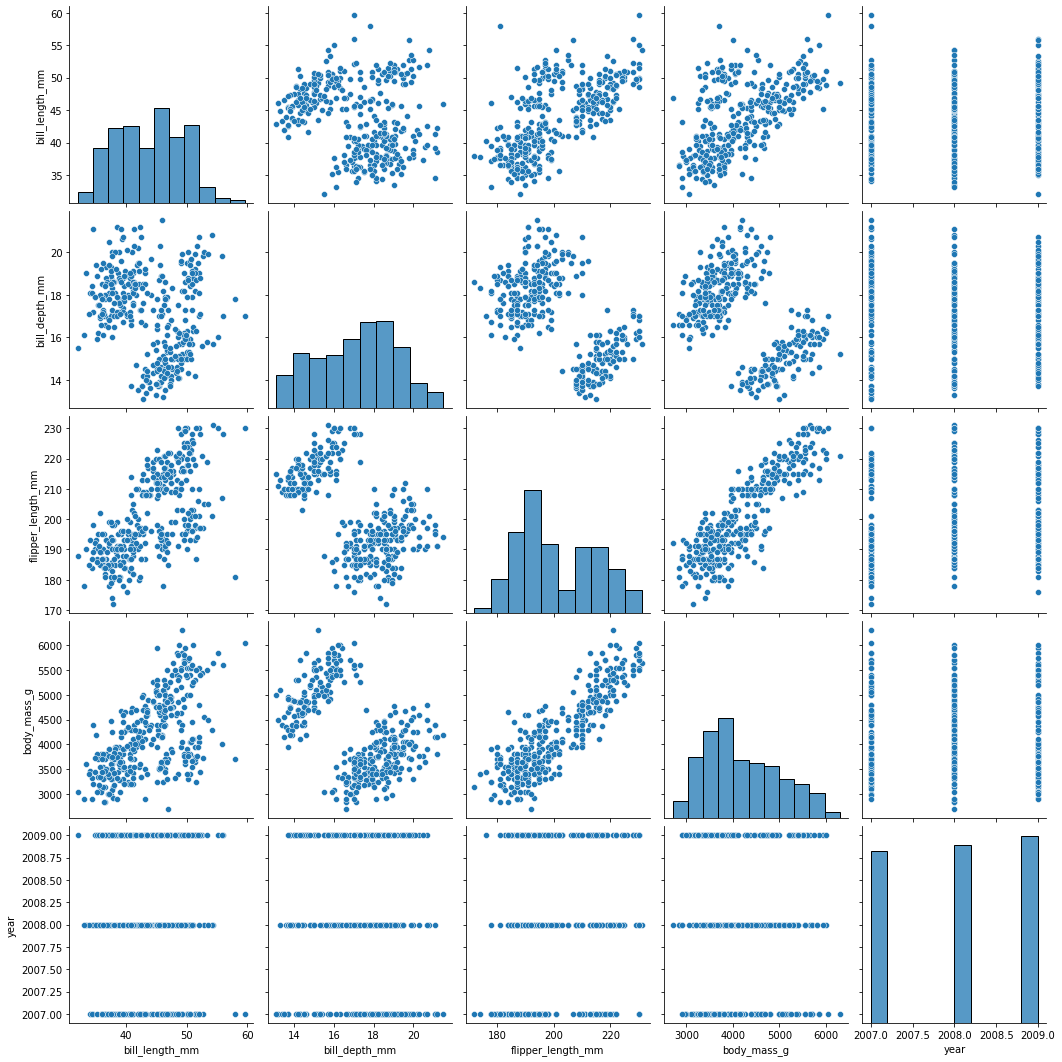

In [ ]:
sns.pairplot(penguins, height=3, diag_kind="hist")

In the pairwise relationships, one can see a separation of points into two or three clusters depending on the selected features. We also notice that, as expected, there seems to be no relation between the year that the measure was made and any other feature.

---

Let's take a closer look on the pairplot of *bill_length* and *flipper_length_mm* which seems to indicate a possible classification into three clusters.

*Note: the three colors correspond to the three different islands*

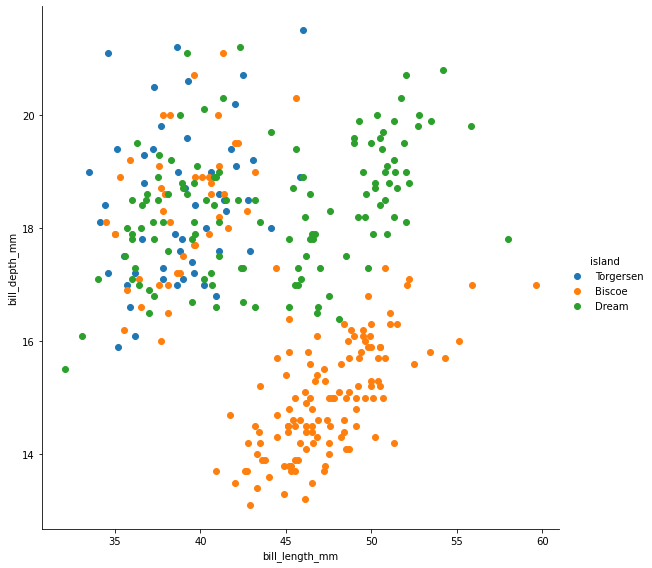

In [ ]:
sns.FacetGrid(penguins, hue="island", height=8) \
   .map(plt.scatter, "bill_length_mm", "bill_depth_mm") \
   .add_legend()

## Data Cleaning



Let's take a look again at the amount of missing data per feature.

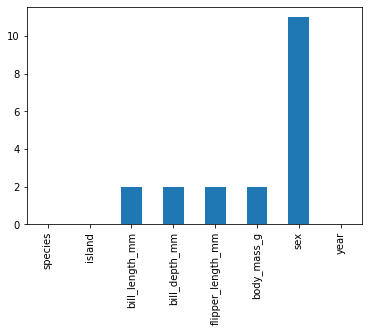

In [ ]:
penguins.isnull().sum().plot.bar(x="Features", y="Missing Values")

Now, let's take a closer look on the rows which have missing values:

In [ ]:
penguins[penguins.isnull().any(axis=1)]

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
8,Adelie,Torgersen,34.1,18.1,193.0,3475.0,NaN,2007
9,Adelie,Torgersen,42.0,20.2,190.0,4250.0,NaN,2007
10,Adelie,Torgersen,37.8,17.1,186.0,3300.0,NaN,2007
11,Adelie,Torgersen,37.8,17.3,180.0,3700.0,NaN,2007
47,Adelie,Dream,37.5,18.9,179.0,2975.0,NaN,2007
178,Gentoo,Biscoe,44.5,14.3,216.0,4100.0,NaN,2007
218,Gentoo,Biscoe,46.2,14.4,214.0,4650.0,NaN,2008
256,Gentoo,Biscoe,47.3,13.8,216.0,4725.0,NaN,2009
268,Gentoo,Biscoe,44.5,15.7,217.0,4875.0,NaN,2009


We can clearly see that line 3 and 271 can be dropped from our dataset as they only contain missing values except the *island* (therefore it would be impossible to deduce correctly the species on the sole basis of this data):

In [ ]:
penguins.drop(index=[3,271], inplace=True)
penguins = penguins.reset_index().drop(['index'], axis=1)

The only missing values left are related to the *sex*, let's replace these missing values by 'male' or 'female' randomly:

In [ ]:
fill_list = ["male", "female"]
penguins['sex'] = penguins['sex'].fillna(pd.Series(np.random.choice(fill_list, size=len(penguins.index))))

## Data Encoding

Since *sex* is a binary categorical feature we encode the values to 0 (female) and 1 (male).

We also encode the *island* categorical feature. In this case, we use **OneHotEncoding**: two binary columns are created to indicate if the penguin is on a certain island - 0 - or is not - 1. The presence of the penguin in the third island is infered when the penguin is not in any of the two islands represented by the columns, that is, the value of the two columns is 0.

*Note: Another encoding solution would have been to replace island values by 0, 1 or 2 but it seemed less suitable because it could be interpreted like if value 2 is more distant from 0 than 1 (which is not the case here).*

In [ ]:
dummies = pd.get_dummies(penguins[['island','sex']], drop_first=True)
penguins = penguins.drop(['island','sex'],axis=1)
penguins = pd.concat([penguins,dummies],axis=1)

Let's visualize the data after the encoding:

In [ ]:
penguins.take(np.random.permutation(len(penguins))[:10])

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year,island_Dream,island_Torgersen,sex_male
59,Adelie,35.7,16.9,185.0,3150.0,2008,0,0,0
154,Gentoo,50.0,15.2,218.0,5700.0,2007,0,0,1
95,Adelie,38.1,18.6,190.0,3700.0,2008,1,0,0
224,Gentoo,46.5,14.8,217.0,5200.0,2008,0,0,0
259,Gentoo,43.3,14.0,208.0,4575.0,2009,0,0,0
149,Adelie,36.0,17.1,187.0,3700.0,2009,1,0,0
251,Gentoo,48.5,15.0,219.0,4850.0,2009,0,0,0
307,Chinstrap,51.0,18.8,203.0,4100.0,2008,1,0,1
228,Gentoo,51.1,16.3,220.0,6000.0,2008,0,0,1
35,Adelie,38.8,20.0,190.0,3950.0,2007,1,0,1


## Data Reduction

We can directly exclude any correlation between the year of registration of the penguins and the species so we drop this feature.

In [ ]:
penguins = penguins.drop(["year"], axis=1)

We also drop the label column because we don't need to use it for the unsupervised classification. 

*Note: We keep a record of the labels just to evaluate the performance of our models.*

In [ ]:
target_labels = penguins[['species']]
penguins = penguins.drop(['species'], axis=1)

As we mentioned in the Data Exploration section, we will drop *flipper_length_mm* to improve the final performance

In [ ]:
penguins = penguins.drop(["flipper_length_mm"], axis=1)

Finally, we also drop the feature *sex_male* since dropping improved the final performance. We believe it might be negatively affecting the performance due to our addition of random values to fill in the missing values.

In [ ]:
penguins = penguins.drop(["sex_male"], axis=1)

Let's visualize the data after the reduction:

In [ ]:
penguins.take(np.random.permutation(len(penguins))[:10])

,bill_length_mm,bill_depth_mm,body_mass_g,island_Dream,island_Torgersen
98,43.2,18.5,4100.0,1,0
48,42.3,21.2,4150.0,1,0
267,44.5,15.7,4875.0,0,0
304,40.9,16.6,3200.0,1,0
276,51.3,19.2,3650.0,1,0
47,36.0,17.9,3450.0,1,0
269,47.2,13.7,4925.0,0,0
77,36.2,16.1,3550.0,0,1
199,44.9,13.3,5100.0,0,0
192,49.6,16.0,5700.0,0,0


## Data Scaling

We noticed that we have mixed numerical data in our dataset, where the features are measured in different units (mm and g), then these values aren't really comparable. Therefore, to give a more distributed weight to the features, we scale the data using **StandardScaler**. This will transform the features to have mean 0 and variance 1. Because we do not have severe outliers, the scaling should result in a similar range of values for all features.



In [ ]:
# Split the dataset into continuous and non-continuous features
non_numeric_features = penguins.select_dtypes(exclude=[np.float])
numeric_features = penguins.select_dtypes(include=[np.float])

# Scale the continuous features using StandardScaler
scaler = StandardScaler()
scaler.fit(numeric_features)
numeric_scaled = scaler.transform(numeric_features)

# Combine the scaled features and the encoded categorical features into the penguins dataset
penguins = pd.DataFrame(numeric_scaled, columns=numeric_features.columns)
penguins = pd.concat([
              pd.DataFrame(numeric_scaled, columns=numeric_features.columns),
              non_numeric_features],axis=1)

Let's visualize the data after the scaling:

In [ ]:
penguins.take(np.random.permutation(len(penguins))[:10])

,bill_length_mm,bill_depth_mm,body_mass_g,island_Dream,island_Torgersen
127,-0.902842,-0.025949,-1.438288,0,1
178,0.711364,-1.090910,1.808541,0,0
223,0.784737,-0.786635,1.121712,0,0
202,0.839767,-1.547322,1.371468,0,0
110,0.307813,1.596848,0.497321,0,0
284,0.491245,0.329038,-0.501703,1,0
274,0.472902,0.379750,-0.876337,1,0
112,-0.315858,1.191149,0.091468,0,0
264,1.390065,-0.431649,1.621224,0,0
298,0.509588,0.379750,-1.126093,1,0


# K-means



## Silhouette and Elbow analysis

In the following section we will analyze the optimal number of cluster to compute with K-Means algorithm. To achieve this we will use two different techniques, the **Silhouette** and **Elbow** analysis.

For 2 clusters the average silhouette_score is : 0.470306115597076
For 3 clusters the average silhouette_score is : 0.4521423954607027
For 4 clusters the average silhouette_score is : 0.4085118983312534
For 5 clusters the average silhouette_score is : 0.36903865837557415
For 6 clusters the average silhouette_score is : 0.36199922816888236
For 7 clusters the average silhouette_score is : 0.3555845056947601
For 8 clusters the average silhouette_score is : 0.3594538397095472


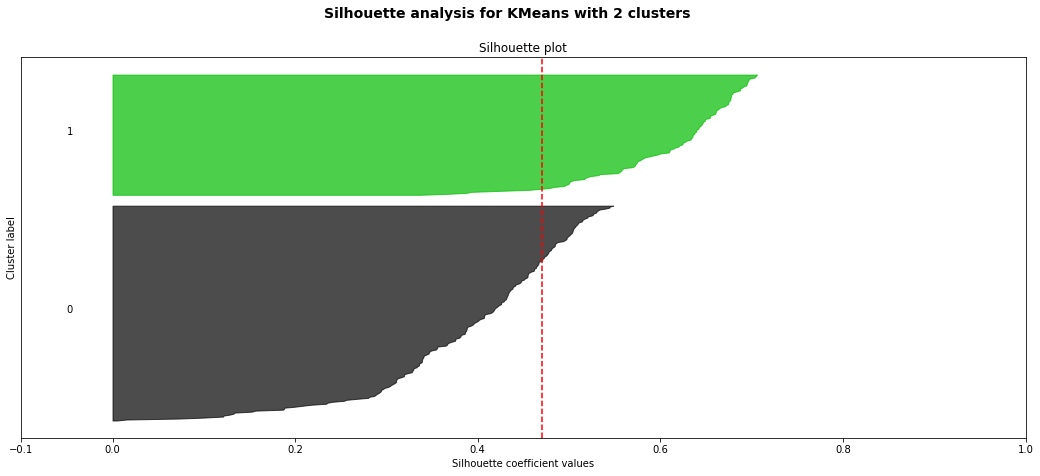

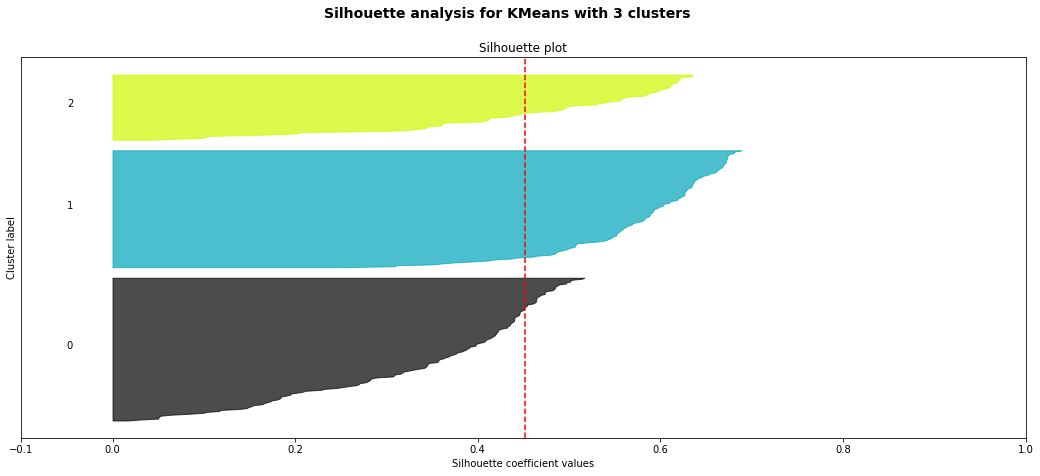

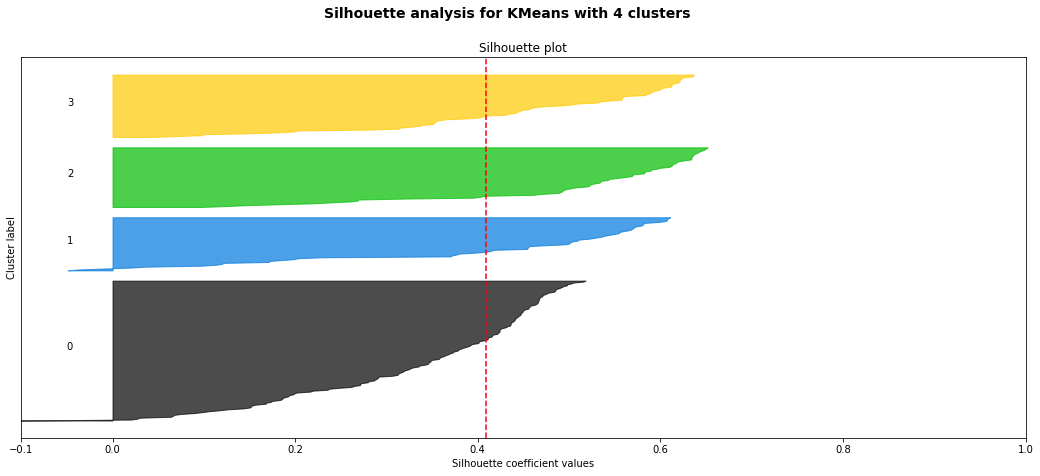

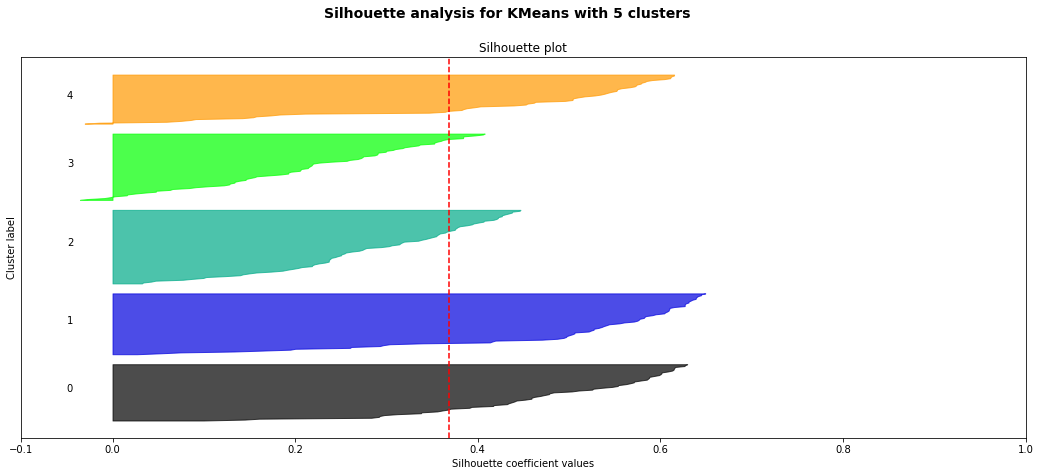

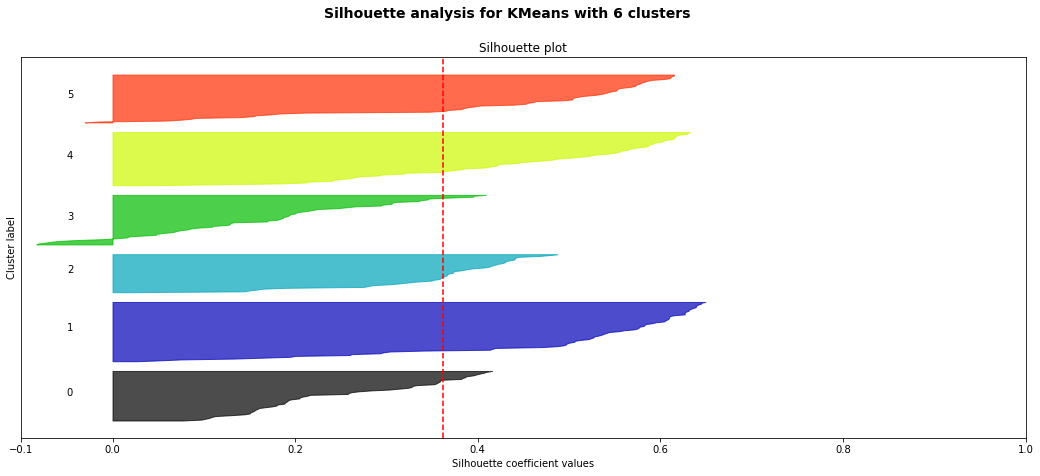

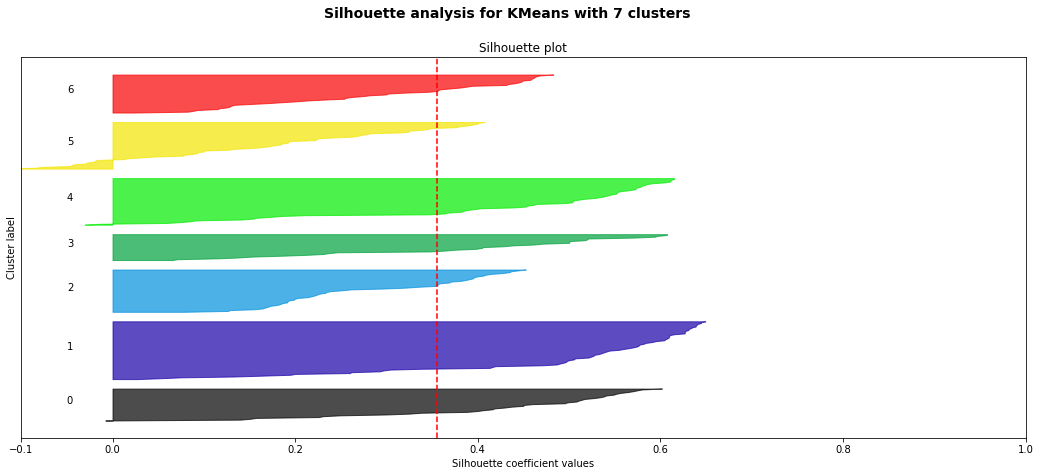

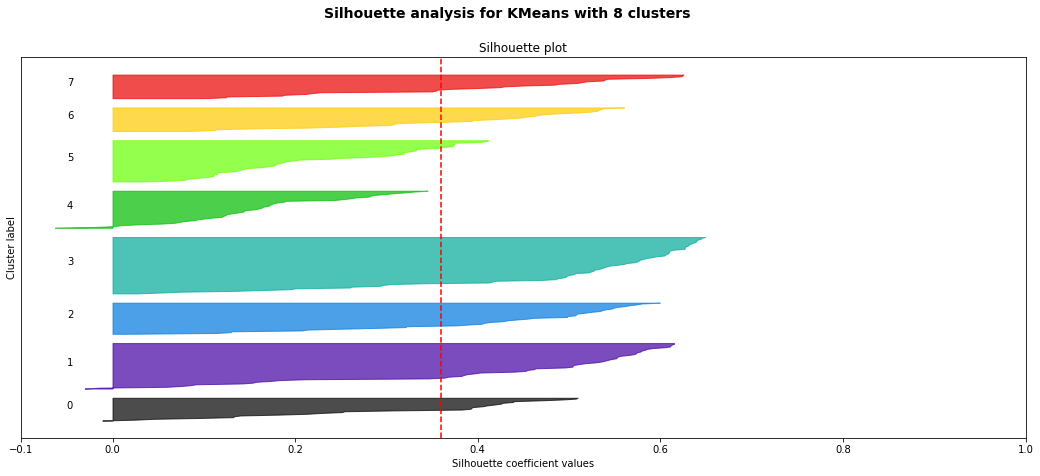

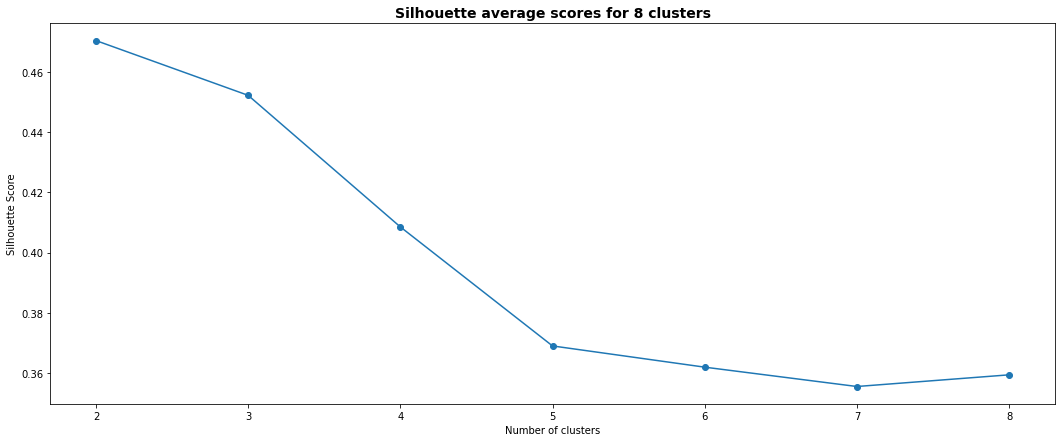

In [ ]:
num_clusters = range(2,9) # we will analyse n_clusters from 2 to 9
silhouette_scores = []
SSE = []

for n_clusters in num_clusters:

    # Create a subplot
    fig, a = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # Initializing the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmeans = KMeans(n_clusters=n_clusters, random_state=10)
    kmeans.fit(penguins)

    labels_pred = kmeans.predict(penguins)

    #Computing the average silhouette_score
    sil_avg_score = metrics.silhouette_score(penguins, labels_pred)
    print("For",n_clusters, "clusters",
          "the average silhouette_score is :", sil_avg_score)

    # Computing the silhouette scores for each sample
    sil_samples_score = metrics.silhouette_samples(penguins, labels_pred)

    silhouette_scores.append(sil_avg_score)

    #Computing k means inertia for elbow analysis
    SSE.append(kmeans.inertia_)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        sil_values = \
            sil_samples_score[labels_pred == i]
        sil_values.sort()

        size_cluster = sil_values.shape[0]
        y_upper = y_lower + size_cluster

        color = cm.nipy_spectral(float(i) / n_clusters)
        a.fill_betweenx(np.arange(y_lower, y_upper),
                          0, sil_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Adding cluster number label
        a.text(-0.05, y_lower + 0.5 * size_cluster, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    # Setting low plot limit to -0.1 since the aren't silhouettes from -0.1
    a.set_xlim([-0.1, 1])
    a.set_title("Silhouette plot")
    a.set_xlabel("Silhouette coefficient values")
    a.set_ylabel("Cluster label")

    # Adding line of average silhouette score
    a.axvline(x=sil_avg_score, color="red", linestyle="--")
    a.set_yticks([])  # Clear the yaxis labels / ticks
    a.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(('Silhouette analysis for KMeans with ' + str(n_clusters) + ' clusters'),
                 fontsize=14, fontweight='bold')

plt.show()

# Plot of silhouette average score values
fig, a = plt.subplots(1, 1)
fig.set_size_inches(18, 7)
plt.plot(num_clusters, silhouette_scores, marker='o')
plt.title('Silhouette average scores for ' + str(n_clusters) + ' clusters', fontsize=14, fontweight='bold')
a.set_xlabel('Number of clusters')
a.set_ylabel('Silhouette Score')

plt.show()

We have plotted 2 different sort of figures to analyze the silhouette results.

Firstly we can observe silhouttes for different number of clusters, where the values of the silhouette ranges from -1 to +1. A value +1 indicates that the sample is far away from the neighboring clusters, 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.

Secondly we plotted the average silhouette value for each number of clusters.

Observing the outputs it can be seen that the silhouettes with higher average values are the ones corresponding to 2 and 3 clusters numbers, which suggests that K=2 clusters might the optimal result.

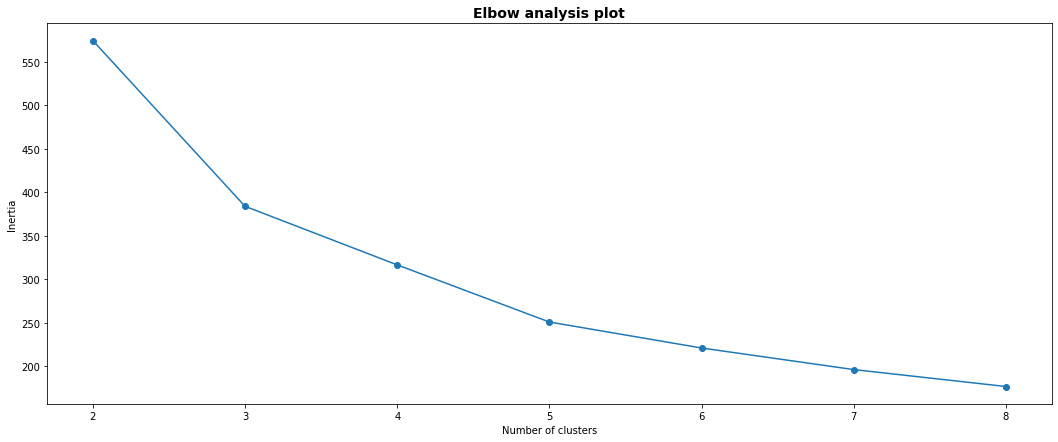

In [ ]:
fig, a = plt.subplots(1, 1)
fig.set_size_inches(18, 7)
plt.plot(num_clusters, SSE, marker='o')
plt.title('Elbow analysis plot', fontsize=14, fontweight='bold')
a.set_xlabel('Number of clusters')
a.set_ylabel('Inertia')
plt.show()

The elbow analysis plot shows the inertia of the K-Means for different number of clusters. The inertia is defined as the sum of squared distances of samples to their closest cluster center, i.e. SSE.

It can be seen that the output of the elbow analysis plot indicates that the optimal number of clusters is K=3. 

Comparing both analysis results we choose to use K=3 since the elbow plot suggest that and is the second highest average silhouette value. Also the number corresponds to what we know from the dataset, which contains data of 3 penguin species.

## Assessment

Now, we will assess the performance of the k-means algorithm with the k chosen in the previous section (k=3).

---

We first run k-means again and get the predicted labels.

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=10)
labels_pred = kmeans.fit_predict(penguins)

In [ ]:
replacer = {"species": {"Adelie": 0, "Gentoo": 1, "Chinstrap": 2}}
labels_true = target_labels.replace(replacer)

In [ ]:
labels_true = labels_true.values.ravel()
labels_pred = labels_pred.ravel()

We plot the contingency matrix to see how many cluster predictions the model did right. The y axis are the true lables and the x axis are the predicted labels.

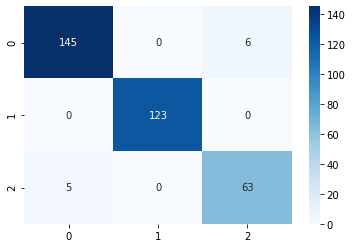

In [ ]:
cf_matrix = metrics.cluster.contingency_matrix(labels_true, labels_pred)
sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='d')

We calculate the Adjusted Rand Index. This metric measures the similarity between the real assignment and the predicted one. Random label assigmenments have ARIs close to 0 and perfect labels have ARIs close to 1.0 and it's based on the number of pairs that are in the same clusters in the real and predicted labels and the ones that are in different ones.

In [ ]:
ari = metrics.adjusted_rand_score(labels_true, labels_pred)
print('The adjusted rand index of the k-means clustering is: %.2f'%(ari))

The adjusted rand index of the k-means clustering is: 0.91


We calculate the Mutual Information Score, which tells us the amount of information that the two clustering have in common based on the entropy for each partition set. Random clusters have AMI close to 0.0 while perfect ones have AMIs 1.0.

In [ ]:
ami = metrics.adjusted_mutual_info_score(labels_true, labels_pred)
print('The adjusted mutual info score of the k-means clustering is: %.2f'%(ami))

The adjusted mutual info score of the k-means clustering is: 0.88




We calculate the V-measure, which is a combination of two concepts:

* homogeneity: each cluster contains only members of a single class.
* completeness: all members of a given class are assigned to the same cluster.

The ideal V-measure is 1.0 while the worst is 0.0.

In [ ]:
v_measure = metrics.v_measure_score(labels_true, labels_pred)
print('The v measure of the k-means clustering is: %.2f'%(v_measure))

The v measure of the k-means clustering is: 0.88


Finally, we calculate the silhouette coefficient again for the k chosen. The silhouette coeficient is based in evaluation two important concepts:

* The mean distance between a sample and all other points in the same class.
* The mean distance between a sample and all other points in the next nearest cluster.

The silhouette score ranges from -1 to 1 and is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.

In [ ]:
silhouette = metrics.silhouette_score(penguins, labels_pred)
print('The silhouette score of the k-means clustering is: %.2f'%(silhouette))

The silhouette score of the k-means clustering is: 0.45


Lastly, we will plot the samples in a tree dimensional space, considering the continuous features so we can visualize the predicted clusters.

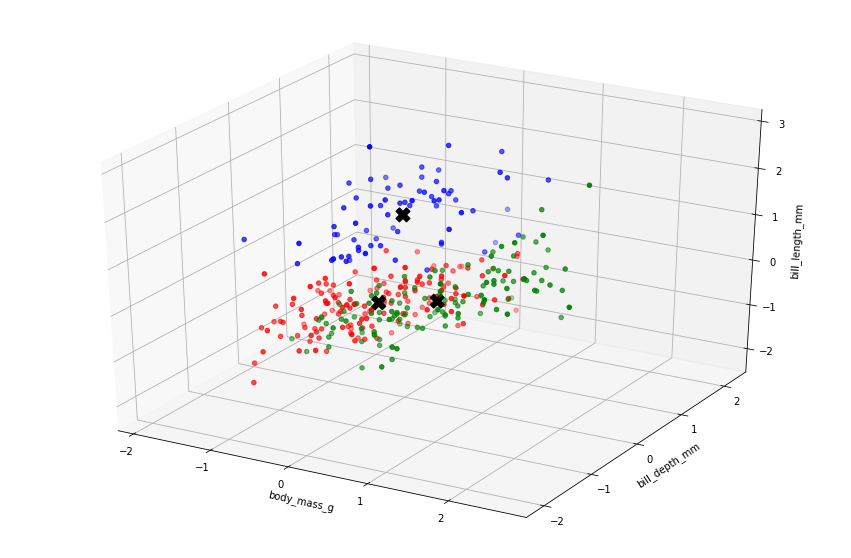

In [ ]:
filtered_label0 = penguins[labels_pred == 0]
filtered_label1 = penguins[labels_pred == 1]
filtered_label2 = penguins[labels_pred == 2]

fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection="3d")

ax.scatter(filtered_label0["body_mass_g"], filtered_label0["bill_depth_mm"], filtered_label0["bill_length_mm"],color="red")
ax.scatter(filtered_label1["body_mass_g"], filtered_label1["bill_depth_mm"], filtered_label1["bill_length_mm"],color="green")
ax.scatter(filtered_label2["body_mass_g"], filtered_label2["bill_depth_mm"], filtered_label2["bill_length_mm"],color="blue")

ax.set_xlabel('body_mass_g')
ax.set_ylabel('bill_depth_mm')
ax.set_zlabel('bill_length_mm')

centers = kmeans.cluster_centers_
ax.scatter(centers[:, 2], centers[:, 1], centers[:,0], marker='X',
                c="black", alpha=1, s=200, edgecolor='k')

# Spectral Clustering

## Similarity

In this section we compute the pairwise distance and similarity for each pair of samples of the dataset. Afterwards this similarity is set as the weight of the edges between the nodes in the connectivity graph analysis. It is worth to highlight that we choose the euclidean distance and for the similarity we consider the Gaussian similarity function with the squared standard deviation of the distance as scaling factor since it is a common practice.

In [ ]:
def get_distance(a, b):
  # Calculate the distance between a and b with the euclidean norm
  return np.linalg.norm(a-b)

def get_similarity(distance, std=1):
  # Calculate the similarity as the exponential of the square of the distance,
  # considering a scaling factor of std
  return np.exp(-np.square(distance)/(2*(std**2)))

We plot the frequency distribution of the distances so we know the range of values and can use this information to define the variables in the connectivity graphs.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


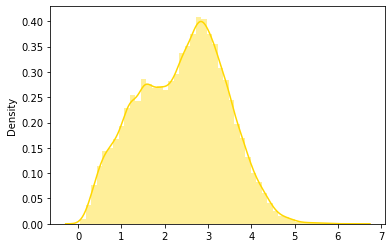

In [ ]:
distances = []

# Loop through all combinations of rows of the dataset
for index, row in penguins.iterrows():
  for index_other, row_other in penguins.iterrows():
    if index < index_other: # ensures that each pair is analysed just once
      distance = get_distance(row.values, row_other.values)
      distances.append(distance)

sns.distplot(distances, hist=True, color='gold')
distance_std = np.std(distances, axis=0)

We also plot the frequency distribution of the similarities, where we can see that the high distances were mapped to 0 and the small distances were mapped to values close to one.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


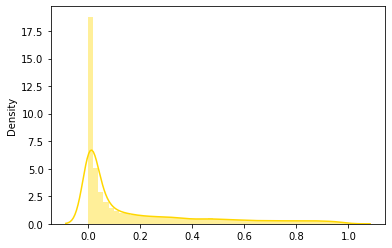

In [ ]:
similarities = []

# Loop through all combinations of rows of the dataset
for index, row in penguins.iterrows():
  for index_other, row_other in penguins.iterrows():
    if index < index_other: # ensures that each pair is analysed just once
      distance = get_distance(row.values, row_other.values)
      similarity = get_similarity(distance, std=distance_std)
      similarities.append(similarity)

sns.distplot(similarities, hist=True, color='gold')

## Connectivity Graph

In this section we will define four kind of similarity graphs that we test for the dataset. In the similarity graphs, the nodes are equivalente to a sample of the dataset (a row) and the edges express the similarity between them.



*   **Completely connected graph (CCG):** In this graph every pair of nodes are connected by an edge with weight equal to the similarity between the two nodes.

* **Epsilon-neighborhood graph (ENG):**
 In this graph a two vertices are connected by an edge if their distance is less than a parameter epsilon. We also choose to set the weight of the edges as the similarity between the connected nodes for this graph.

* **Symmetric k-nearest neighbor graph (SKNG):** In this graph two vertices are connected if one is among the k-nearest neighbors of the other or vice versa.

* **Mutual k-nearest neighbor graph (MKNG):** In this graph two vertices are connected if one is among the k-nearest neighbors of the other **and** vice versa.

In [ ]:
def build_completly_connected_graph(dataset, distance_std):
  # Create an empty undirected graph
  graph = nx.Graph()

  # Loop through all combinations of rows of the dataset
  for index, row in dataset.iterrows():
    graph.add_node(index)
    for index_other, row_other in dataset.iterrows():
      if index < index_other: # ensures that each pair is analysed just once
        distance = get_distance(row.values, row_other.values)
        similarity = get_similarity(distance, std=distance_std)
        graph.add_edge(index, index_other, weight=similarity) # add edge to graph
  return graph

def build_epsilon_neighborhood_graph(dataset, distance_std, epsilon=0.8):
  # Create an empty undirected graph
  graph = nx.Graph()

  # Loop through all combinations of rows of the dataset
  for index, row in dataset.iterrows():
    graph.add_node(index)
    for index_other, row_other in dataset.iterrows():
      if index < index_other: # ensures that each pair is analysed just once
        distance = get_distance(row.values, row_other.values)
        similarity = get_similarity(distance, std=distance_std)
        if distance < epsilon:
          graph.add_edge(index, index_other, weight=similarity) # add edge to graph
  return graph

def build_symmetric_k_nearest_neighbor_graph(dataset, distance_std, k=15):
  # Create an empty undirected graph
  graph = nx.Graph()

  # Create a nearest neighbor model and fit to the data
  knn = NearestNeighbors(n_neighbors=(k+1))
  knn.fit(dataset)

  # Loop through all combinations of rows of the dataset
  for index, row in dataset.iterrows():
    graph.add_node(index)
    # Get the k nearest neighbors from the current row and its euclidean distance
    distances, neighbors = knn.kneighbors(row.values.reshape(1, -1), return_distance=True)
    for i_neighbor in range(1, k + 1): # loop through current row's nearest neighbors
      similarity = get_similarity(distances[0, i_neighbor], std=distance_std)
      graph.add_edge(index, neighbors[0, i_neighbor], weight=similarity) # add edge to graph
  return graph

def build_mutual_k_nearest_neighbor_graph(dataset, distance_std, k=15):
  # Create an empty undirected graph
  graph = nx.Graph()

  # Create a nearest neighbor model and fit to the data
  knn = NearestNeighbors(n_neighbors=(k+1))
  knn.fit(dataset)

  # Create a dictionary to hold the nearest neighbors of the previous rows
  nearest_neighbors = {}

  # Loop through all combinations of rows of the dataset
  for index, row in dataset.iterrows():
    graph.add_node(index)
    # Get the k nearest neighbors from the current row and its euclidean distance
    distances, neighbors = knn.kneighbors(row.values.reshape(1, -1), return_distance=True)
    nearest_neighbors[index] = neighbors[0] # add nearest neighbors to the history
    for i_neighbor in range(1, k + 1): # loop through current row's nearest neighbors
      # If the knn of the neighbor has already been calculated
      if neighbors[0, i_neighbor] in nearest_neighbors:
        # If the current row was also a nearest neighbor of the neighbor
        if index in nearest_neighbors[neighbors[0, i_neighbor]]:
          # Calculate similarity and add edge to graph
          similarity = get_similarity(distances[0, i_neighbor], std=distance_std)
          graph.add_edge(index, neighbors[0, i_neighbor], weight=similarity)
  return graph

We also define a function to plot the graphs in a way the helps with visualization and choice of the parameters.

We plot the graph in a layout where the nodes connected with an edge with higher weight are closer than the nodes connected by edges with lower weight. We color the nodes of the graph according to the connected component it belongs to.

In [ ]:
def plot_graph(graph):
  colorlist = ['gold', 'darkorange', 'forestgreen', 'teal', 'navy', 'indianred', 'blueviolet', 'darkgreen', 'firebrick', 'olive']
  pos = nx.spring_layout(graph)
  connected_components = nx.connected_components(graph)

  for index, cc_nodes in enumerate(connected_components):
    subgraph = graph.subgraph(nodes=cc_nodes)
    if index > 9:
      color = 'black'
    else:
      color = colorlist[index]
    nx.draw(subgraph, pos=pos, edge_color='grey', node_color=color, node_size=10)

We will now plot an example of each similarity graph. The choice of the parameters (k-nearest-neighbors and epsilon) was done by trial an error observing the impact of the parameters in the graph visualization (connected components). The parameters ploted below are the ones that we have considered the best for the combination of final features selected.

### Plotting Completely Connected Graph

The number of edges of the graph is 58311 with 342 nodes


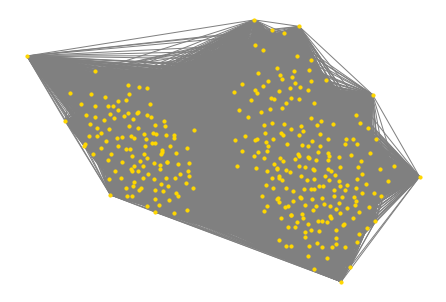

In [ ]:
g = build_completly_connected_graph(penguins, distance_std)
print('The number of edges of the graph is %d with %d nodes'%(g.number_of_edges(), g.number_of_nodes()))
nx.draw(g, node_color='gold', pos=nx.spring_layout(g), edge_color='grey', node_size=10)

### Plotting Epsilon-neighborhood Graph



The number of edges of the graph is 5900 with 342 nodes


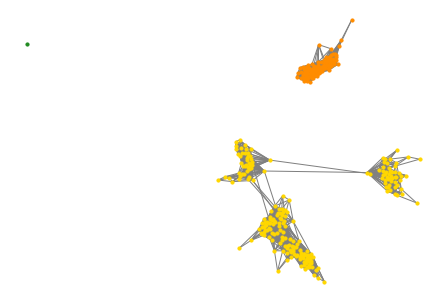

In [ ]:
g = build_epsilon_neighborhood_graph(penguins, distance_std, epsilon=1.01)
print('The number of edges of the graph is %d with %d nodes'%(g.number_of_edges(), g.number_of_nodes()))
plot_graph(g)

### Plotting Symmetric K-nearest Neighbor Graph

The number of edges of the graph is 1139 with 342 nodes


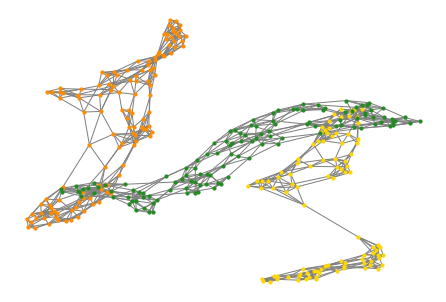

In [ ]:
g = build_symmetric_k_nearest_neighbor_graph(penguins, distance_std, k=5)
print('The number of edges of the graph is %d with %d nodes'%(g.number_of_edges(), g.number_of_nodes()))
plot_graph(g)

### Plotting Mutual K-nearest Neighbor Graph

The number of edges of the graph is 1587 with 342 nodes


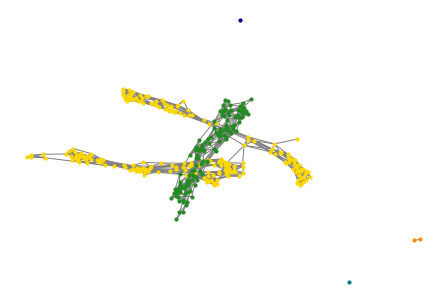

In [ ]:
g = build_mutual_k_nearest_neighbor_graph(penguins, distance_std, k=13)
print('The number of edges of the graph is %d with %d nodes'%(g.number_of_edges(), g.number_of_nodes()))
plot_graph(g)

## Clustering Operation

In [ ]:
def get_normalized_laplacian_matrix(graph):
  # Get the laplacian matrix
  L = nx.laplacian_matrix(graph)
  L = L.todense() # convert it from sparse to dense numpy matrix

  # Build the degree matrix
  d = np.diagonal(L) # get the diagonal from the laplacian matrix
  D = np.diag(d) # build a diagonal matrix with the diagonal of the laplacian
  
  # Calculate the normalized laplacian matrix
  Ld = np.linalg.pinv(D)*L
  # Ld = np.linalg.sqrtm(D)*L*np.linalg.sqrtm(D)

  return Ld

In [ ]:
def get_sorted_eig(matrix):
  # Calculate the eigenvalues and eigenvectors of the matrix
  lbda, V = np.linalg.eig(matrix)

  # Sort the eigenvalues and eigenvectors from the smallest eigenvalue to the biggest
  sorted_index = np.argsort(lbda)
  sorted_lbda = lbda[sorted_index]
  sorted_V = V[:,sorted_index]

  return sorted_lbda, sorted_V

In [ ]:
def plot_eigengap(sorted_lbda):
  plt.figure()
  plt.title("Eigenvalues")
  plt.xlabel("Eigenvalue Position")
  plt.ylabel("Eigenvalue")
  plt.scatter(np.arange(len(sorted_lbda)), sorted_lbda)

  plt.figure()
  plt.title("Eigenvalues")
  plt.xlabel("Eigenvalue Position")
  plt.ylabel("Eigenvalue")
  plt.scatter(np.arange(2, 10), sorted_lbda[1:9])

## Clustering

In this section we compute the spectral clustering with the completely connected graph since it is the one that gave the best results when testing the graphs (the complete log of the tests are in the **excel** (in the annex)). 

To make decision of wich cut criteria we should choose we considered the following two aspects:

*   We want to find a partition such that points in different clusters are dissimilar to each other, that is we want to minimize the between-cluster similarity.

*   We want to find a partition such that points in the same cluster are similar to each other, that is we want to maximize the within-cluster similarities.

Both *Normalized-cut* and *Ratio-cut* criteria successfully fullfill the first point, however only *Normalized-cut* fulfills the seconds point, which in the end produces more balanced partitions.

Therefore, we decided to use the *Normalized-cut* criterion and for that reason we ended up using the Normalized Laplacian matrix.

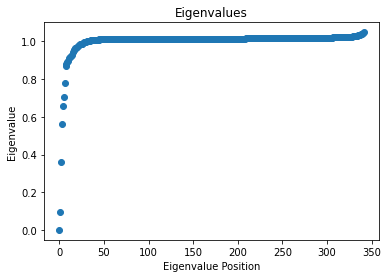

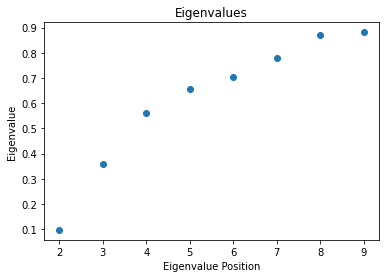

In [ ]:
G = build_completly_connected_graph(penguins, distance_std)
Ld = get_normalized_laplacian_matrix(G)
lbda, V = get_sorted_eig(Ld)
plot_eigengap(lbda)

As we can see in the previous figures the biggest "eigen gap" is in between the second and third eigen value. This suggests that the optimal number of clusters should be K=2

In [ ]:
#Computing the exact distance
print("Distance between second and third eigen value: ", lbda[2]-lbda[1])
print("Distance between second and third eigen value: ", lbda[3]-lbda[2])

Distance between second and third eigen value:  0.2629562615510506
Distance between second and third eigen value:  0.20067961751285424


### Eigenvectors analysis

Let's take a look at first 3 corresponding eigenvectors. 

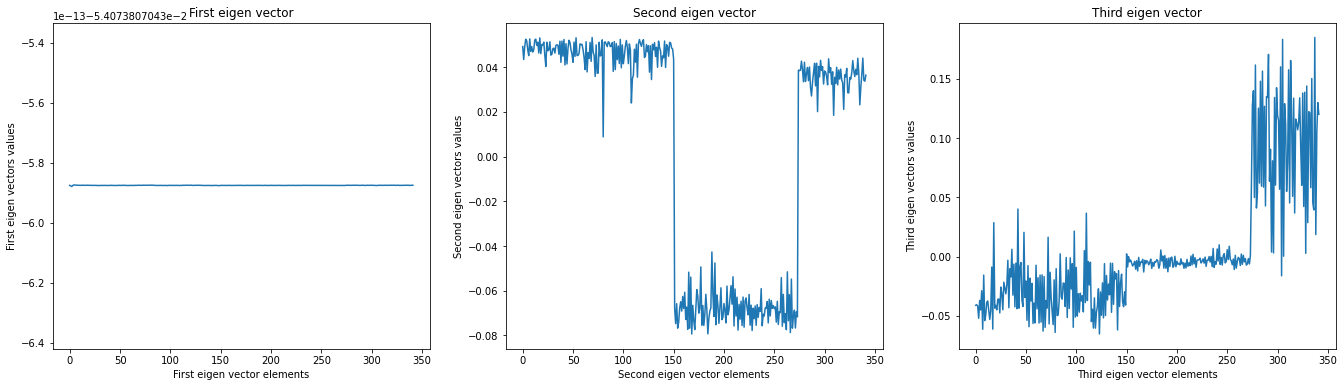

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(23, 6)
ax1.plot(V[:,0])
ax2.plot(V[:,1])
ax3.plot(V[:,2])
ax1.set_title('First eigen vector')
ax1.set_xlabel('First eigen vector elements')
ax1.set_ylabel('First eigen vectors values')
ax2.set_title('Second eigen vector')
ax2.set_xlabel('Second eigen vector elements')
ax2.set_ylabel('Second eigen vectors values')
ax3.set_title('Third eigen vector')
ax3.set_xlabel('Third eigen vector elements')
ax3.set_ylabel('Third eigen vectors values')
plt.show()

In light of the eigen vector figures we can denote the following facts:


*   The first eigen vector is a constant value since we are using completely connected graph. This means that there is only one component, which makes sense according to the multiplicity of the eigenvalue zero (There is only one eigenvalue corresponding to zero, the first eigen value).

*   We can observe that the second eigen vector has most of the information of the nodes of the clusters. It detects two clusters clearly identified by some positive values around 0.04 and some negative values arounf -0.07.

*   The third cluster, although is much more distorted than the second one, also shows information about the clustering, which would mean that the algorithm might also considering 3 clusters instead of 2. This makes sense observing that the second biggest eigen gap is in between the third and forth eigen values, meaning that K=3 is a potential optimal number of clusters.



Since we have previous knowledge about the number of penguin species and, also based on the elbow and silhouette analysis of the K-Means section, we run the K-Means with K=3 taking the first 3 eigen vectors.

In [ ]:
k = 3
V_cluster = V[:, :k]
V_df = pd.DataFrame(V_cluster)
kmeans = KMeans(n_clusters=k, random_state=10)
cluster_labels = kmeans.fit_predict(V_df)

After the execution of K-Means on the 3 first eigen vectors we can plot the second and third vectors along the predicted labels.

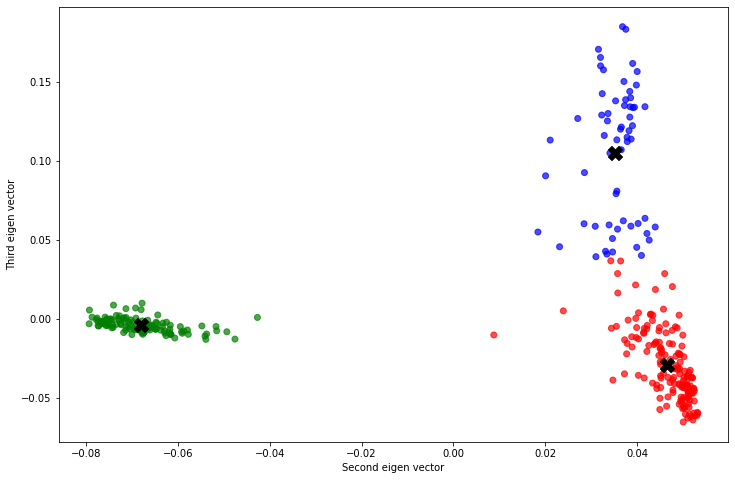

In [ ]:
LABEL_COLOR_MAP = {0:'r', 1:'g', 2:'b'}
label_color = [LABEL_COLOR_MAP[l] for l in cluster_labels]

fig, ax= plt.subplots(1, 1)
fig.set_size_inches(12, 8)

ax.scatter([V[:,1]],[V[:,2]], c=label_color, alpha=0.7)
ax.set_xlabel('Second eigen vector')
ax.set_ylabel('Third eigen vector')

centers = kmeans.cluster_centers_
ax.scatter(centers[:, 1], centers[:, 2], marker='X',
                c="black", alpha=1, s=200, edgecolor='k')
plt.show()

As it can be observed in the previous figure, the election of K=3 is highly satistactory since the first 3 eigen vectors contain accurate the information of the 3 different clusters.

## Assessment

Now, we will assess the performance of the spectral clustering algorithm with the k chosen in the previous section (k=3).

In [ ]:
replacer = {"species": {"Adelie": 0, "Gentoo": 1, "Chinstrap": 2}}
labels_true = target_labels.replace(replacer)

In [ ]:
labels_true = labels_true.values.ravel()
labels_pred = cluster_labels.ravel()

We plot the contingency matrix to see how many cluster predictions the model did right. The y axis are the true lables and the x axis are the predicted labels.

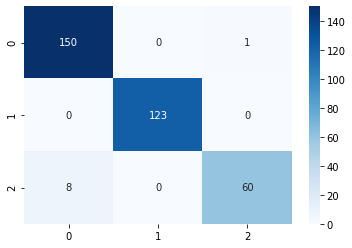

In [ ]:
cf_matrix = metrics.cluster.contingency_matrix(labels_true, labels_pred)
sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='d')

We calculate the Adjusted Rand Index. This metric measures the similarity between the real assignment and the predicted one. Random label assigmenments have ARIs close to 0 and perfect labels have ARIs close to 1.0 and it's based on the number of pairs that are in the same clusters in the real and predicted labels and the ones that are in different ones.

In [ ]:
ari = metrics.adjusted_rand_score(labels_true, labels_pred)
print('The adjusted rand index of the spectral clustering is: %.2f'%(ari))

The adjusted rand index of the spectral clustering is: 0.93


We calculate the Mutual Information Score, which tells us the amount of information that the two clustering have in common based on the entropy for each partition set. Random clusters have AMI close to 0.0 while perfect ones have AMIs 1.0.

In [ ]:
ami = metrics.adjusted_mutual_info_score(labels_true, labels_pred)
print('The adjusted mutual info score of the spectral clustering is: %.2f'%(ami))

The adjusted mutual info score of the spectral clustering is: 0.90


We calculate the V-measure, which is a combination of two concepts:

* homogeneity: each cluster contains only members of a single class.
* completeness: all members of a given class are assigned to the same cluster.

The ideal V-measure is 1.0 while the worst is 0.0.

In [ ]:
v_measure = metrics.v_measure_score(labels_true, labels_pred)
print('The v measure of the spectral clustering is: %.2f'%(v_measure))

The v measure of the spectral clustering is: 0.91


Finally, we calculate the silhouette coefficient again for the k chosen. The silhouette coeficient is based in evaluation two important concepts:

* The mean distance between a sample and all other points in the same class.
* The mean distance between a sample and all other points in the next nearest cluster.

The silhouette score ranges from -1 to 1 and is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.

In [ ]:
silhouette = metrics.silhouette_score(penguins, labels_pred)
print('The silhouette score of the spectral clustering is: %.2f'%(silhouette))

The silhouette score of the spectral clustering is: 0.45


Lastly, we will plot the samples in a tree dimensional space, considering the continuous features so we can visualize the predicted clusters.

Text(0.5, 0, 'bill_length_mm')

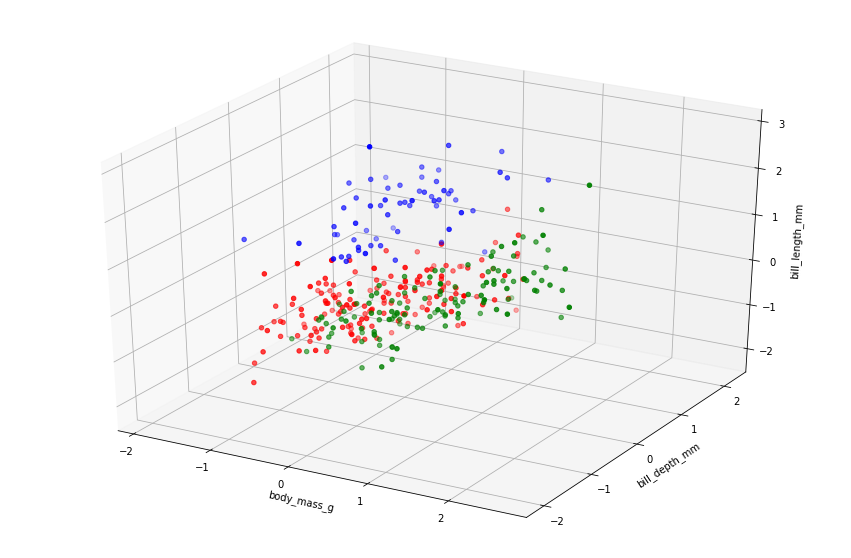

In [ ]:
filtered_label0 = penguins[cluster_labels == 0]
filtered_label1 = penguins[cluster_labels == 1]
filtered_label2 = penguins[cluster_labels == 2]

fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection="3d")

ax.scatter(filtered_label0["body_mass_g"], filtered_label0["bill_depth_mm"], filtered_label0["bill_length_mm"],color="red")
ax.scatter(filtered_label1["body_mass_g"], filtered_label1["bill_depth_mm"], filtered_label1["bill_length_mm"],color="green")
ax.scatter(filtered_label2["body_mass_g"], filtered_label2["bill_depth_mm"], filtered_label2["bill_length_mm"],color="blue")

ax.set_xlabel('body_mass_g')
ax.set_ylabel('bill_depth_mm')
ax.set_zlabel('bill_length_mm')

# ANNEX - Tested combinations

In the next excel sheet we have saved our combinational analysis of parameters to choose the ones that gave the best results.

[Combinatorial analysis.xlsx](https://unice-my.sharepoint.com/:x:/g/personal/florian_spire_etu_unice_fr/ETGWxY-0YjJOtG06bimLEVYBv-YbOT4346s76H7Vw_-ssA?e=5RTeUp)